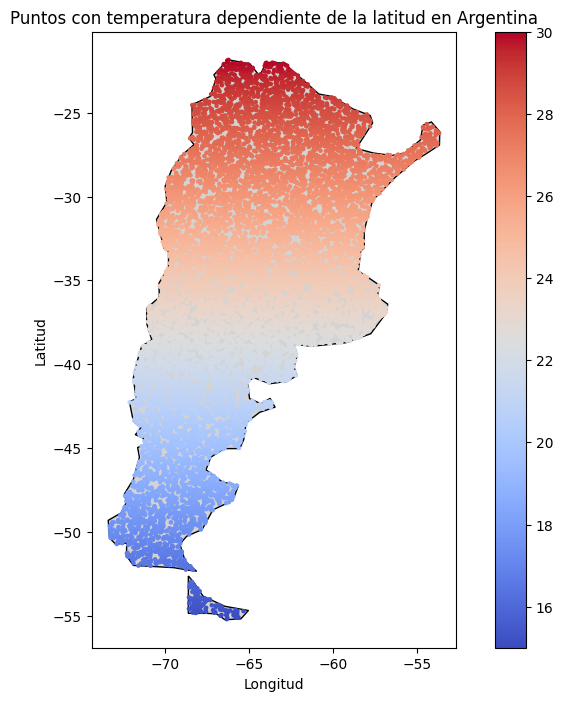

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Función para obtener coordenadas aleatorias dentro del polígono que representa Argentina
def get_random_point_inside_polygon(polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    while True:
        point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(point):
            return point

# Cargar los datos geográficos de Argentina usando Geopandas
argentina = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
argentina = argentina[argentina.name == 'Argentina']
argentina_polygon = argentina.geometry.values[0]

# Generar 10000 coordenadas aleatorias dentro de Argentina
np.random.seed(42)
points = [get_random_point_inside_polygon(argentina_polygon) for _ in range(10000)]

# Asignar valores de temperatura según la latitud (más al sur, temperaturas más bajas; más al norte, temperaturas más altas)
latitudes = [point.y for point in points]
temperaturas = np.interp(latitudes, (min(latitudes), max(latitudes)), (15, 30))

# Crear un DataFrame con las coordenadas de latitud, longitud y temperatura
data = {
    'latitud': [point.y for point in points],
    'longitud': [point.x for point in points],
    'temperatura': temperaturas
}
df = pd.DataFrame(data)

# Crear un GeoDataFrame con las coordenadas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud, df.latitud))

# Dibujar el mapa de Argentina con los puntos coloreados por temperatura
fig, ax = plt.subplots(figsize=(10, 8))
argentina.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, column='temperatura', cmap='coolwarm', markersize=5, legend=True)
plt.title('Puntos con temperatura dependiente de la latitud en Argentina')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


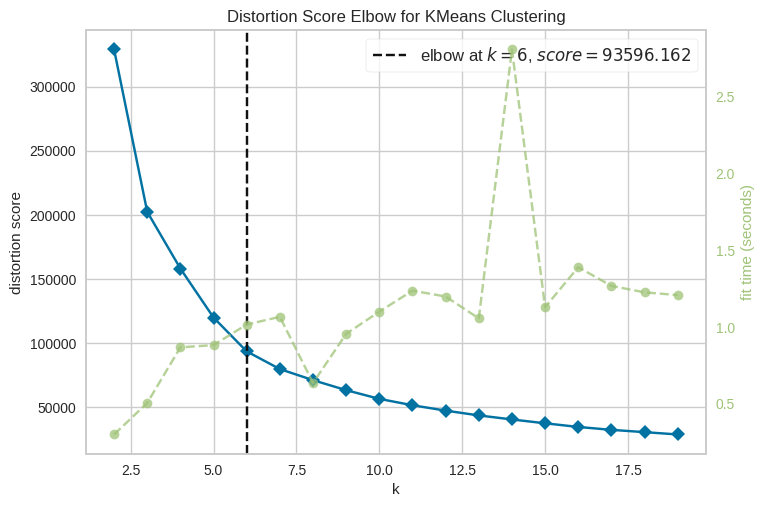

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
k_means = KMeans()
elbow = KElbowVisualizer(k_means, k=(2, 20))
elbow.fit(df)
k_value = elbow.elbow_value_
elbow.show()


In [ ]:
kmeans = KMeans(n_clusters = k_value, random_state = 40, n_init='auto')
kmeans.fit(df)

#count number of records in every cluster
pd.Series(kmeans.labels_).value_counts()


2    2041
4    1719
3    1657
5    1647
0    1561
1    1375
dtype: int64

In [ ]:
def calculate_distance(centroid, X, Y):
    distances = []

    # Unpack the x and y coordinates of the centroid
    c_x, c_y = centroid

    # Iterate over the data points and calculate the distance using the # given formula
    for x, y in list(zip(X, Y)):
        root_diff_x = (x - c_x) ** 2
        root_diff_y = (y - c_y) ** 2
        distance = np.sqrt(root_diff_x + root_diff_y)
        distances.append(distance)

    return distances

In [ ]:

# Obtener el número de puntos
num_points = len(kmeans.cluster_centers_)

# Crear una lista para almacenar los puntos formateados
formatted_points = []

# Iterar a través de los puntos y formatearlos
for i in range(num_points):
    formatted_point = f'c{i+1} = ({kmeans.cluster_centers_[i][1]:.8f},{kmeans.cluster_centers_[i][0]:.8f})'
    formatted_points.append(formatted_point)

# Ejecutar las variables para que estén disponibles en el entorno
for point in formatted_points:
    exec(point)   # con este generamos la Variable
    #print(point)

# Genero centroid_names
centroid_names = []

for i in range(k_value):
    centroid_names.append(formatted_points[i].split('=')[0].strip())

# Crear un bucle for para calcular las distancias y agregar las columnas al dataframe
for centroid_name in centroid_names:
    column_name = f'{centroid_name}_Distance'
    df[column_name] = calculate_distance(eval(centroid_name.lower()), df['longitud'], df['latitud'])
    exec(f"df['{column_name}'] = calculate_distance({centroid_name.lower()}, df['longitud'], df['latitud'])")
    #print(f"df['{column_name}'] = calculate_distance({centroid_name.lower()}, df['longitud'], df['latitud'])")

# Le agrego una "C" a los Id de Centroide
df['Cluster'] = ['C' + str(x) for x in kmeans.labels_]
df.head()

,latitud,longitud,temperatura,c1_Distance,c2_Distance,c3_Distance,c4_Distance,c5_Distance,c6_Distance,Cluster
0,-23.479324,-66.004378,29.264883,8.276709,25.569215,17.551536,2.441296,9.229436,13.466949,C3
1,-35.244217,-58.931408,23.976946,6.442032,17.255385,10.743269,11.289895,8.488570,2.650696,C5
2,-50.037024,-70.328281,17.328059,23.701742,1.433355,9.404709,25.010274,17.696703,16.501395,C1
3,-31.587850,-61.521121,25.620364,3.285887,19.014264,11.386434,6.824474,5.596135,4.556866,C0
4,-49.121045,-69.817649,17.739761,22.654101,0.384842,8.397076,24.006596,16.704578,15.454806,C1


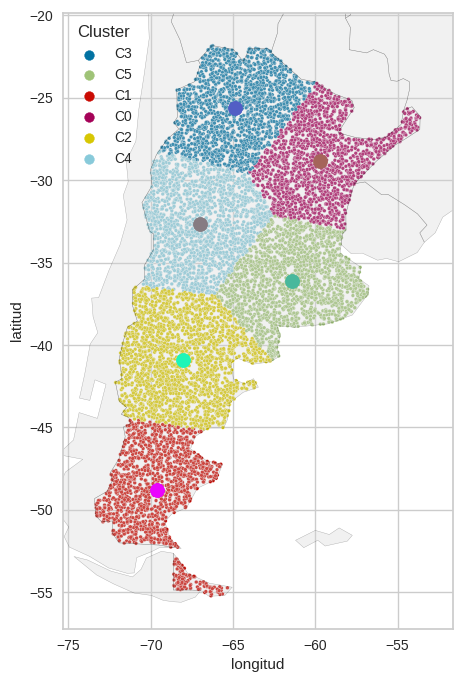

In [ ]:
# Crear una figura más grande para el gráfico
plt.figure(figsize=(12, 8))

# Crear el gráfico de dispersión con seaborn
ax = sns.scatterplot(x="longitud", y="latitud", data=df, hue="Cluster", s=7)

# Cargar el shapefile con geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)

# Ajustar los límites del mapa para enfocarse en el área de los puntos
ax.set_xlim(df['longitud'].min() - 2, df['longitud'].max() + 2)
ax.set_ylim(df['latitud'].min() - 2, df['latitud'].max() + 2)

# Lista de colores aleatorios en formato hexadecimal
colors = [f'#{"".join([hex(int(np.random.rand()*16))[2:] for _ in range(6)])}' for _ in range(7)]

# Crear un bucle for para calcular las distancias y agregar las columnas al dataframe
for centroid_name, color in zip(centroid_names, colors):
    plt.scatter(eval(centroid_name.lower())[0], eval(centroid_name.lower())[1], marker='o', s=100, c=color)
    exec(f"plt.scatter({centroid_name.lower()}[0], {centroid_name.lower()}[1], marker='o', s=100, c='{color}')")
    #print(f"plt.scatter({centroid_name.lower()}[0], {centroid_name.lower()}[1], marker='o', s=100, c='{color}')")

plt.show()

# **TEMPERATURAS**

In [ ]:
temperature_stats = df.groupby('Cluster')['temperatura'].agg(['mean', 'min', 'max', 'median', 'std', 'count']).reset_index()

temperature_stats_sorted = pd.DataFrame(temperature_stats.sort_values(by='mean', ascending=False))

# Imprimir el resultado
print(temperature_stats_sorted)


  Cluster       mean        min        max     median       std  count
3      C3  28.295467  26.529360  30.000000  28.339668  0.862483   1657
0      C0  26.853797  25.028240  28.970322  26.843100  0.916996   1561
4      C4  25.133250  23.251523  27.115975  25.137824  0.944923   1719
5      C5  23.571984  21.446672  25.359122  23.554923  0.830745   1647
2      C2  21.424872  19.536808  23.410138  21.438512  1.002727   2041
1      C1  17.885048  15.000000  19.788103  18.015989  1.123780   1375


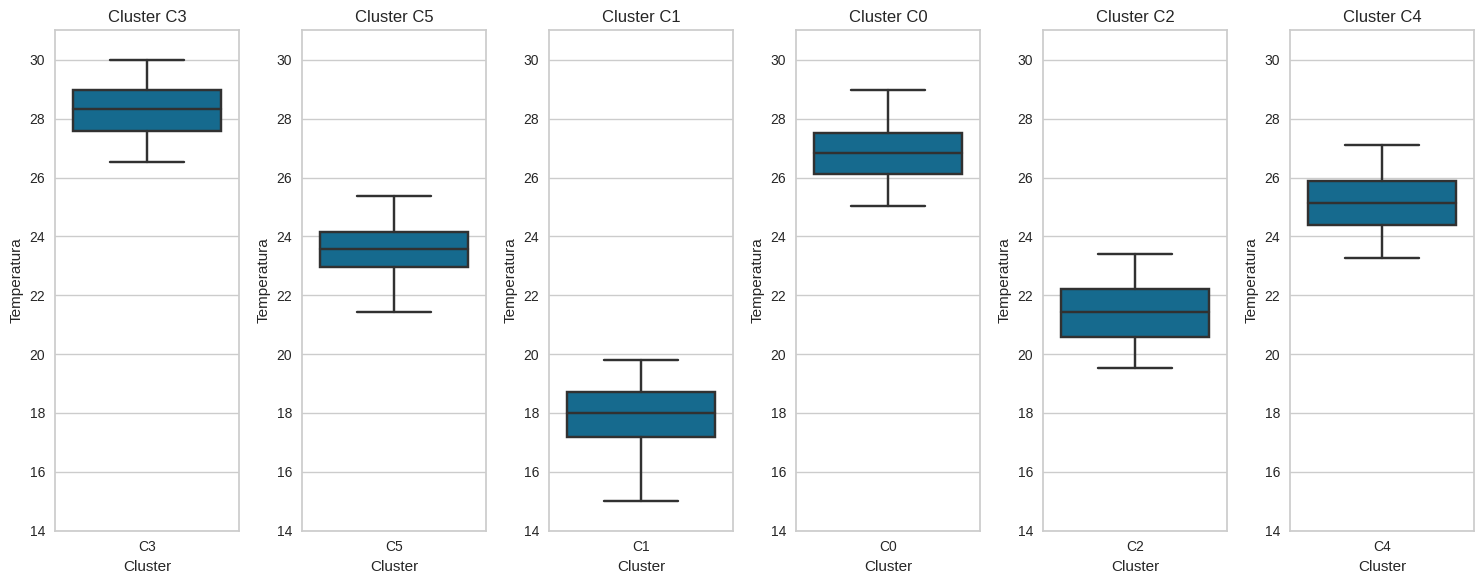

In [ ]:

# Crear una figura más grande para los subplots
plt.figure(figsize=(15, 6))

# Crear subplots, uno para cada cluster
num_clusters = len(df['Cluster'].unique())
for i, cluster in enumerate(df['Cluster'].unique(), 1):
    plt.subplot(1, num_clusters, i)
    sns.boxplot(x='Cluster', y='temperatura', data=df[df['Cluster'] == cluster])
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Cluster')
    plt.ylabel('Temperatura')
    plt.ylim(14, 31)  # Establecer límites en el eje Y

plt.tight_layout()  # Ajustar el diseño de los subplots
plt.show()


# **CONCLUSION**
Temperatura Media por cada Region y Latitud

In [ ]:
temperature_stats_sorted[['Cluster', 'mean']]

,Cluster,mean
3,C3,28.295467
0,C0,26.853797
4,C4,25.133250
5,C5,23.571984
2,C2,21.424872
1,C1,17.885048


# **MAPA CON INFORMACION EMERGENTE EN CADA PUNTO**

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import numpy as np
import folium

# Función para obtener coordenadas aleatorias dentro del polígono que representa Argentina
def get_random_point_inside_polygon(polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    while True:
        point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(point):
            return point

# Cargar los datos geográficos de Argentina usando Geopandas
argentina = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
argentina = argentina[argentina.name == 'Argentina']
argentina_polygon = argentina.geometry.values[0]

# Generar 10000 coordenadas aleatorias dentro de Argentina
np.random.seed(42)
points = [get_random_point_inside_polygon(argentina_polygon) for _ in range(10000)]

# Asignar valores de temperatura según la latitud (más al sur, temperaturas más altas; más al norte, temperaturas más bajas)
latitudes = [point.y for point in points]
temperaturas = np.interp(latitudes, (min(latitudes), max(latitudes)), (15, 30))

# Crear un DataFrame con las coordenadas de latitud, longitud y temperatura
data = {
    'latitud': [point.y for point in points],
    'longitud': [point.x for point in points],
    'temperatura': temperaturas
}
df = pd.DataFrame(data)

# Crear un GeoDataFrame con las coordenadas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud, df.latitud))

# Crear un mapa interactivo con folium
map_center = [np.mean(latitudes), np.mean([point.x for point in points])]
mymap = folium.Map(location=map_center, zoom_start=6)

# Agregar círculos como marcadores para cada punto con información emergente
for i, row in gdf.iterrows():
    popup = f"Latitud: {row['latitud']:.4f}<br>Longitud: {row['longitud']:.4f}<br>Temperatura: {row['temperatura']:.2f}°C"
    folium.CircleMarker(location=[row['latitud'], row['longitud']], radius=1, popup=popup, fill=True, color='blue', fill_opacity=0.7).add_to(mymap)

# Mostrar el mapa interactivo
mymap


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df.describe()

,latitud,longitud,temperatura
count,10000.000000,10000.000000,10000.000000
mean,-35.381684,-65.167463,23.915158
std,7.697000,4.000679,3.459552
min,-55.216616,-73.329099,15.000000
25%,-40.575868,-68.377627,21.580541
50%,-34.753897,-65.663261,24.197328
75%,-29.055472,-62.137626,26.758585
max,-21.843796,-53.663279,30.000000
